### Importing necessary libraries, loading the dataset and running initial checks

In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [5]:
dataset = pd.read_csv('Datasets/loan_data 2.csv')
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [31]:
dataset.isnull().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [23]:
# Check the datatypes of the columns and convert if necessary 

dataset.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [26]:
# Checking few columns with their unique values to convert them to correct datatypes
for i in dataset.drop('Loan_ID', axis =1).select_dtypes(include=['object']).columns.tolist():
    print(i, dataset[i].unique())

Gender ['Male' 'Female' nan]
Married ['Yes' 'No']
Dependents ['1' '0' '2' '3+' nan]
Education ['Graduate' 'Not Graduate']
Self_Employed ['No' 'Yes' nan]
Property_Area ['Rural' 'Urban' 'Semiurban']
Loan_Status ['N' 'Y']


#### Check for relationships of different values of categorical features (more than two classes) with the dependent variable to detect ordinality

C:\Users\subhabrat.biswal\AppData\Local\Temp\ipykernel_20664\3851824622.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=approval_ratio.index, y='Approval_Ratio', data=approval_ratio, palette='viridis')


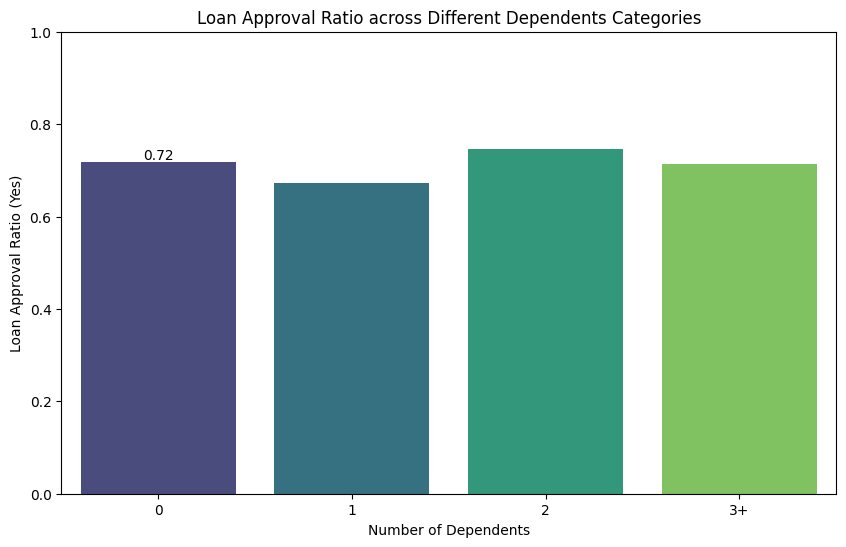

In [11]:
# Calculate the approval ratio for each category in 'Dependents'
approval_ratio = dataset.pivot_table(index='Dependents', columns='Loan_Status', aggfunc='size', fill_value=0)
approval_ratio['Approval_Ratio'] = approval_ratio['Y'] / (approval_ratio['Y'] + approval_ratio['N'])

# Plot the approval ratio
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=approval_ratio.index, y='Approval_Ratio', data=approval_ratio, palette='viridis')

ax.bar_label(ax.containers[0], fmt='%.2f')

plt.title('Loan Approval Ratio across Different Dependents Categories')
plt.xlabel('Number of Dependents')
plt.ylabel('Loan Approval Ratio (Yes)')
plt.ylim(0, 1)

plt.show()


C:\Users\subhabrat.biswal\AppData\Local\Temp\ipykernel_20664\2704689228.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=approval_ratio.index, y='Approval_Ratio', data=approval_ratio, palette='viridis')


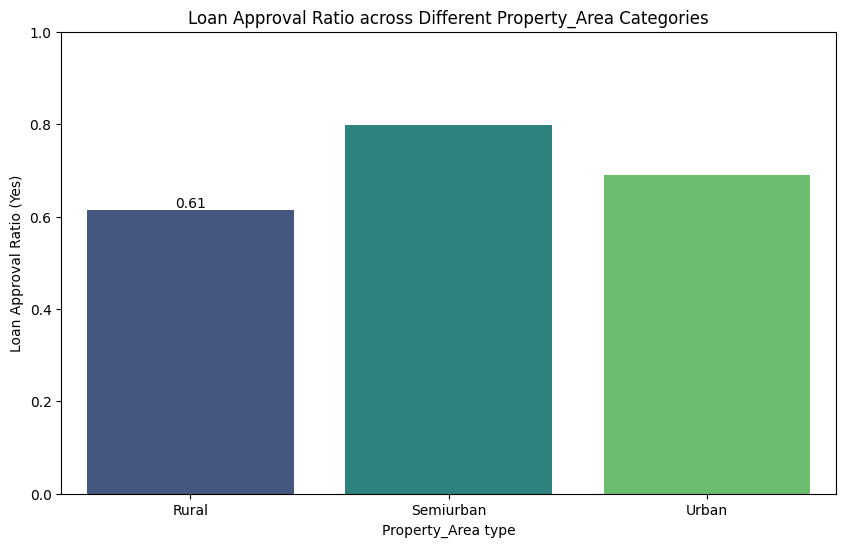

In [12]:
# Calculate the approval ratio for each category in 'Property_Area'
approval_ratio = dataset.pivot_table(index='Property_Area', columns='Loan_Status', aggfunc='size', fill_value=0)
approval_ratio['Approval_Ratio'] = approval_ratio['Y'] / (approval_ratio['Y'] + approval_ratio['N'])

# Plot the approval ratio
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=approval_ratio.index, y='Approval_Ratio', data=approval_ratio, palette='viridis')

ax.bar_label(ax.containers[0], fmt='%.2f')

plt.title('Loan Approval Ratio across Different Property_Area Categories')
plt.xlabel('Property_Area type')
plt.ylabel('Loan Approval Ratio (Yes)')
plt.ylim(0, 1)

plt.show()

### preprocessing the data before model training

We will impute, encode and scale the columns as required using a preprocessor object

In [6]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def data_preprocessing(df):
    # Drop the 'Loan_ID' column
    df.drop('Loan_ID', axis=1, inplace=True)
    
    # Separate categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Columns for one-hot encoding
    one_hot_cols = ['Dependents', 'Property_Area']
    label_cols = ['Gender', 'Married', 'Education', 'Self_Employed']
    target_col = 'Loan_Status'
    
    # Handle numerical and one-hot encoded columns 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),  
                ('scaler', StandardScaler())  
            ]), numerical_cols),
            
            ('one_hot', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')) 
            ]), one_hot_cols)
        ],
        remainder='drop'  # Drop columns that are not specified
    )

    # Apply transformations
    transformed_data = preprocessor.fit_transform(df)
    
    # Get OHE feature names after transformation
    one_hot_feature_names = list(preprocessor.named_transformers_['one_hot'].named_steps['encoder'].get_feature_names_out(one_hot_cols))
    feature_names = numerical_cols + one_hot_feature_names
    
    # Create a DataFrame with the transformed data
    transformed_data_df = pd.DataFrame(transformed_data, columns=feature_names)
    
    # Label encode the categorical columns outside of the pipeline
    label_encoder = LabelEncoder()
    for col in label_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Encode the target variable 'Loan_Status' separately
    df[target_col] = label_encoder.fit_transform(df[target_col])
    
    # Combine the processed numerical, one-hot encoded, and label-encoded columns
    final_data = pd.concat([transformed_data_df, df[label_cols], df[target_col]], axis=1)
    
    # Return the final DataFrame with processed data
    return final_data

# Load the dataset
df = pd.read_csv('Datasets/loan_data 2.csv')

# Preprocess the data
processed_data = data_preprocessing(df)

# Output the processed data
print(processed_data.head())
processed_data.to_csv('processed-file.csv', index=False)


   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0         0.707469           0.098695    0.812575          0.275147   
1        -0.408932          -0.546371   -1.376596          0.275147   
2        -0.703019           0.462294    0.530102          0.275147   
3         1.706799          -0.546371    1.271595          0.275147   
4        -0.879330           0.102118   -0.352629          0.275147   

   Credit_History  Dependents_0  Dependents_1  Dependents_2  Dependents_3+  \
0        0.419435           0.0           1.0           0.0            0.0   
1        0.419435           1.0           0.0           0.0            0.0   
2        0.419435           1.0           0.0           0.0            0.0   
3        0.419435           1.0           0.0           0.0            0.0   
4        0.419435           1.0           0.0           0.0            0.0   

   Property_Area_Rural  Property_Area_Semiurban  Property_Area_Urban  Gender  \
0                  1.0  

#### Train the models and choose the model with less FP 

Approach : We will train two classifiers, one an ANN model and another is a stacking classifier using all the classification models as base estimators and SVC as a final estimator

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tensorflow import keras
from keras import layers
import joblib


In [30]:
# Load the transformed dataset for spliiting
def load_data(path, target_col):
    df = pd.read_csv(path)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify will help in class imbalance



In [45]:
# ANN model creation
def ann_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [46]:
#  Stacking classifier creation
def stacking_classifier():
    model = StackingClassifier(
        estimators=[
            ('log_reg', LogisticRegression()),
            ('naive_bayes', GaussianNB()),
            ('kernel_svm', SVC(kernel='rbf', probability=True)),
            ('random_forest', RandomForestClassifier()),
            ('xgboost', XGBClassifier())
        ],
        final_estimator=SVC(probability=True),
        cv=5
    )
    return model


In [24]:
# Model training
def train_models(ann_model, stacking_classifier_model, X_train, y_train):
    ann_model.fit(X_train, y_train, epochs=30, verbose=0)
    stacking_classifier_model.fit(X_train, y_train)
    return ann_model, stacking_classifier_model

In [48]:
# Model evaluation
def evaluate_models(trained_ann_model, trained_stacking_model, X_train, y_train, X_test, y_test):
    # Evaluate the ANN model on training data
    y_train_pred_ann = (trained_ann_model.predict(X_train) > 0.5).astype("int32")
    ann_train_accuracy = accuracy_score(y_train, y_train_pred_ann)
    ann_train_conf_matrix = confusion_matrix(y_train, y_train_pred_ann)
    ann_train_false_positives = ann_train_conf_matrix[0][1]
    ann_train_precision = precision_score(y_train, y_train_pred_ann)
    ann_train_recall = recall_score(y_train, y_train_pred_ann)
    ann_train_f1 = f1_score(y_train, y_train_pred_ann)

    # Evaluate the ANN model on testing data
    y_test_pred_ann = (trained_ann_model.predict(X_test) > 0.5).astype("int32")
    ann_test_accuracy = accuracy_score(y_test, y_test_pred_ann)
    ann_test_conf_matrix = confusion_matrix(y_test, y_test_pred_ann)
    ann_test_false_positives = ann_test_conf_matrix[0][1]
    ann_test_precision = precision_score(y_test, y_test_pred_ann)
    ann_test_recall = recall_score(y_test, y_test_pred_ann)
    ann_test_f1 = f1_score(y_test, y_test_pred_ann)

    # Evaluate the stacking classifier on training data
    y_train_pred_stacking = trained_stacking_model.predict(X_train)
    stacking_train_accuracy = accuracy_score(y_train, y_train_pred_stacking)
    stacking_train_conf_matrix = confusion_matrix(y_train, y_train_pred_stacking)
    stacking_train_false_positives = stacking_train_conf_matrix[0][1]
    stacking_train_precision = precision_score(y_train, y_train_pred_stacking)
    stacking_train_recall = recall_score(y_train, y_train_pred_stacking)
    stacking_train_f1 = f1_score(y_train, y_train_pred_stacking)

    # Evaluate the stacking classifier on testing data
    y_test_pred_stacking = trained_stacking_model.predict(X_test)
    stacking_test_accuracy = accuracy_score(y_test, y_test_pred_stacking)
    stacking_test_conf_matrix = confusion_matrix(y_test, y_test_pred_stacking)
    stacking_test_false_positives = stacking_test_conf_matrix[0][1]
    stacking_test_precision = precision_score(y_test, y_test_pred_stacking)
    stacking_test_recall = recall_score(y_test, y_test_pred_stacking)
    stacking_test_f1 = f1_score(y_test, y_test_pred_stacking)

    # Prepare evaluation results
    evaluation_results = (

        "ANN Model Training Evaluation:\n"
        f"Accuracy: {ann_train_accuracy:.4f}\n"
        f"False Positives: {ann_train_false_positives}\n"
        f"Precision: {ann_train_precision:.4f}\n"
        f"Recall: {ann_train_recall:.4f}\n"
        f"F1 Score: {ann_train_f1:.4f}\n\n"

        "ANN Model Testing Evaluation:\n"
        f"Accuracy: {ann_test_accuracy:.4f}\n"
        f"False Positives: {ann_test_false_positives}\n"
        f"Precision: {ann_test_precision:.4f}\n"
        f"Recall: {ann_test_recall:.4f}\n"
        f"F1 Score: {ann_test_f1:.4f}\n\n"


        "Stacking Model Training Evaluation:\n"
        f"Accuracy: {stacking_train_accuracy:.4f}\n"
        f"False Positives: {stacking_train_false_positives}\n"
        f"Precision: {stacking_train_precision:.4f}\n"
        f"Recall: {stacking_train_recall:.4f}\n"
        f"F1 Score: {stacking_train_f1:.4f}\n\n"

        "Stacking Model Testing Evaluation:\n"
        f"Accuracy: {stacking_test_accuracy:.4f}\n"
        f"False Positives: {stacking_test_false_positives}\n"
        f"Precision: {stacking_test_precision:.4f}\n"
        f"Recall: {stacking_test_recall:.4f}\n"
        f"F1 Score: {stacking_test_f1:.4f}\n"

    )

    # Save evaluation metrics to a text file
    with open("Model Evaluation.txt", "w") as f:
        f.write(evaluation_results)

    # Decide the best model based on fewer false positives on the test set
    if stacking_test_false_positives < ann_test_false_positives:
        best_model = trained_stacking_model
        print("Stacking model is selected as the best model.")
    elif stacking_test_false_positives > ann_test_false_positives:
        best_model = trained_ann_model
        print("ANN model is selected as the best model.")
    else:
        # If both have the same number of false positives, choose the one with greater accuracy
        if stacking_test_accuracy > ann_test_accuracy:
            best_model = trained_stacking_model
            print("Both models have the same false positives. Stacking model is selected due to higher accuracy.")
        else:
            best_model = trained_ann_model
            print("Both models have the same false positives. ANN model is selected due to higher accuracy.")

    return best_model

In [47]:
## Test all the functions till here 

X_train, X_test, y_train, y_test = load_data('processed-file.csv', 'Loan_Status')
#print(X_train, X_test, y_train, y_test)

ann_classifier = ann_model()
stacked_classifier  = stacking_classifier()

trained_ann, trained_stack = train_models(ann_classifier, stacked_classifier, X_train, y_train)

final_predictor = evaluate_models(trained_ann, trained_stack, X_train, y_train, X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Both models have the same false positives. Stacking model is selected due to higher accuracy.


In [ ]:
def final_loan_predictor():
    